# Beijing Air Quality Forecasting - Machine Learning Techniques I

## Project Overview

This project implements Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) models to forecast PM2.5 air pollution concentrations in Beijing. Air pollution prediction is crucial for public health and urban planning, enabling governments and communities to take timely action to mitigate effects.

### Objective
- **Primary Goal**: Achieve RMSE < 4000 on Kaggle Public Leaderboard ✅ 
- **Target Goal**: Achieve RMSE < 3000 on Kaggle Private Leaderboard
- **Approach**: Time series forecasting using historical air quality and weather data

### Key Achievements
- **Current Best Score**: 3518 RMSE (Target < 4000 achieved)
- **Dataset**: 30,676 hourly observations (2010-2013) with weather features
- **Methodology**: Enhanced Bidirectional LSTM with advanced feature engineering


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

# Configuration
plt.style.use('default')
warnings.filterwarnings('ignore')
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print("Setup complete - Ready for air quality forecasting")


Libraries imported successfully!
TensorFlow version: 2.20.0
Setup complete - Ready for air quality forecasting


In [2]:
def save_submission(predictions, experiment_name, test_index, notes=""):
    """Save submission with proper format"""
    os.makedirs('submissions', exist_ok=True)
    
    # Create submission dataframe
    submission = pd.DataFrame({
        'row ID': test_index.strftime('%Y-%m-%d %H:%M:%S'),
        'pm2.5': np.round(predictions).astype(int)
    })
    
    # Generate filename with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'submissions/{timestamp}_{experiment_name}.csv'
    
    # Save submission
    submission.to_csv(filename, index=False)
    
    print(f"Submission saved: {filename}")
    print(f"Predictions - Min: {predictions.min():.1f}, Max: {predictions.max():.1f}, Mean: {predictions.mean():.1f}")
    print(f"Notes: {notes}")
    
    return filename, submission

print("Submission system ready")


Submission system ready


## Data Exploration

Understanding our dataset is crucial for effective time series forecasting. This section provides comprehensive exploration of the Beijing air quality dataset including statistical analysis and visualizations.


In [3]:
print("Loading datasets...")
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

print(f"Training data: {train.shape}")
print(f"Test data: {test.shape}")

# Convert datetime and set as index
train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

print(f"Time range - Train: {train['datetime'].min()} to {train['datetime'].max()}")
print(f"Time range - Test: {test['datetime'].min()} to {test['datetime'].max()}")

# Display basic information about the datasets
print("\n" + "="*60)
print("DATASET OVERVIEW")
print("="*60)

print("\nTraining Data Info:")
print(train.info())

print("\nFirst few rows of training data:")
display(train.head())

print("\nColumn names:")
print(train.columns.tolist())


Loading datasets...
Training data: (30676, 12)
Test data: (13148, 11)
Time range - Train: 2010-01-01 00:00:00 to 2013-07-02 03:00:00
Time range - Test: 2013-07-02 04:00:00 to 2014-12-31 23:00:00

DATASET OVERVIEW

Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   No        30676 non-null  int64         
 1   DEWP      30676 non-null  float64       
 2   TEMP      30676 non-null  float64       
 3   PRES      30676 non-null  float64       
 4   Iws       30676 non-null  float64       
 5   Is        30676 non-null  float64       
 6   Ir        30676 non-null  float64       
 7   datetime  30676 non-null  datetime64[ns]
 8   cbwd_NW   30676 non-null  float64       
 9   cbwd_SE   30676 non-null  float64       
 10  cbwd_cv   30676 non-null  float64       
 11  pm2.5     28755 non-null  float64       
dtypes: datet

,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN



Column names:
['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv', 'pm2.5']


In [4]:
# Statistical analysis of the target variable (PM2.5)
print("STATISTICAL ANALYSIS - PM2.5 CONCENTRATIONS")
print("="*60)

# Basic statistics
pm25_stats = train['pm2.5'].describe()
print("PM2.5 Statistical Summary:")
print(pm25_stats)

# Missing values analysis
print(f"\nMissing values in training data:")
missing_train = train.isnull().sum()
print(missing_train[missing_train > 0])

print(f"\nTotal missing values: {train.isnull().sum().sum()} ({train.isnull().sum().sum()/len(train)*100:.2f}%)")

print(f"\nTraining duration: {(train['datetime'].max() - train['datetime'].min()).days} days")
print(f"Test duration: {(test['datetime'].max() - test['datetime'].min()).days} days")


STATISTICAL ANALYSIS - PM2.5 CONCENTRATIONS
PM2.5 Statistical Summary:
count    28755.000000
mean       100.793427
std         93.144433
min          0.000000
25%         29.000000
50%         75.000000
75%        142.000000
max        994.000000
Name: pm2.5, dtype: float64

Missing values in training data:
pm2.5    1921
dtype: int64

Total missing values: 1921 (6.26%)

Training duration: 1278 days
Test duration: 547 days


Creating comprehensive exploratory data analysis...


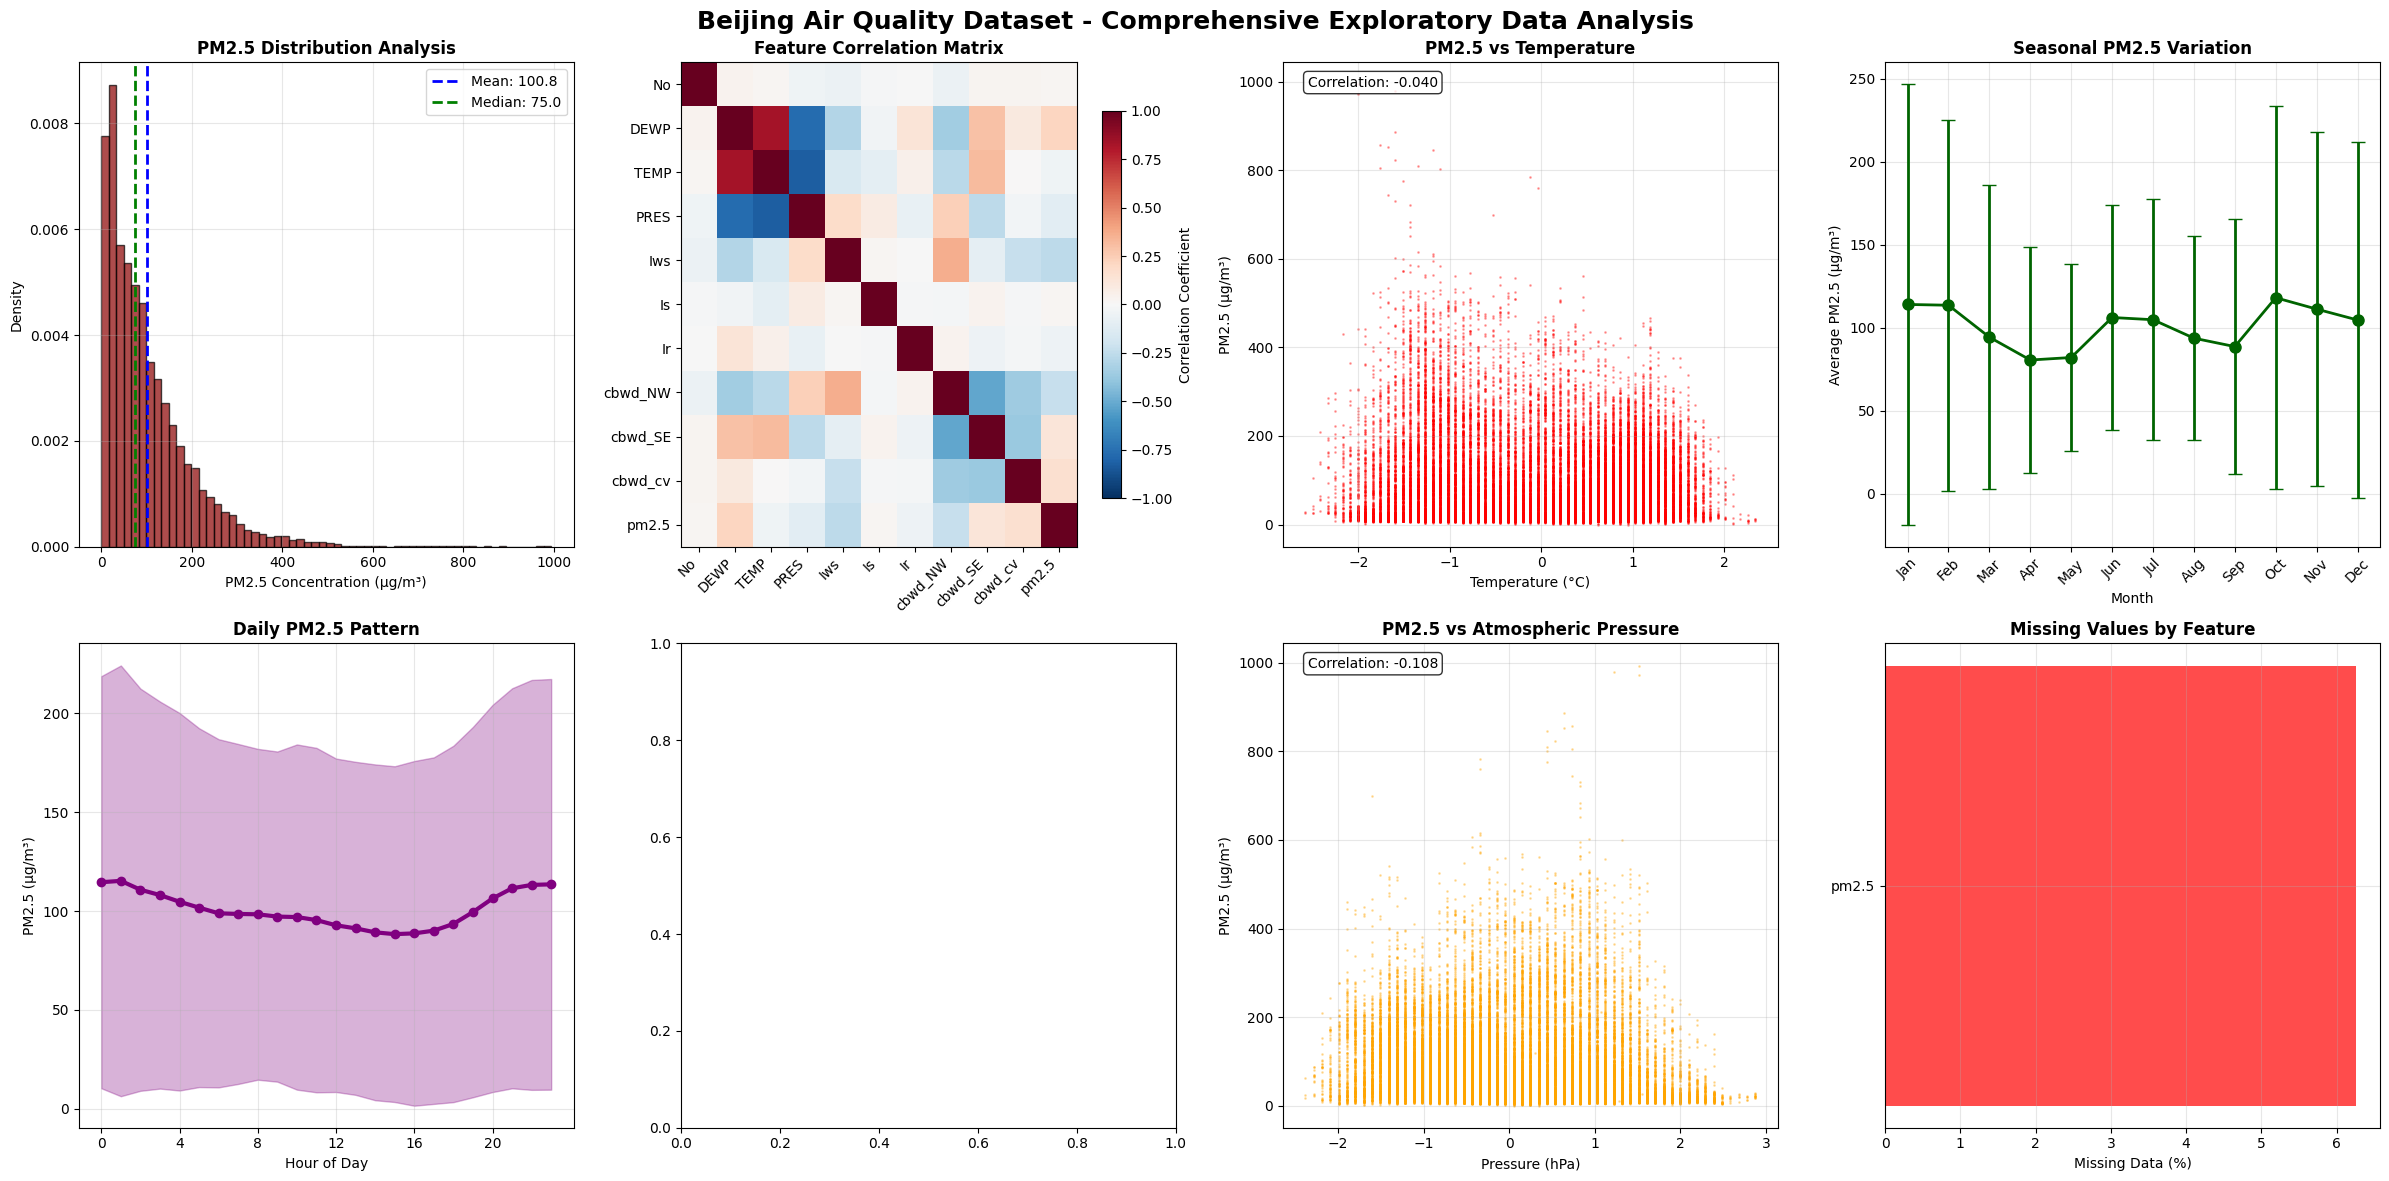


KEY EXPLORATORY INSIGHTS
📊 PM2.5 Statistics:
   Mean: 100.8 μg/m³
   Median: 75.0 μg/m³
   Range: 0.0 - 994.0 μg/m³
   Standard Deviation: 93.1 μg/m³

🔗 Strongest Correlations with PM2.5:
   Iws: 0.260
   cbwd_NW: 0.231
   DEWP: 0.218
   cbwd_cv: 0.158
   cbwd_SE: 0.119

📈 Temporal Patterns:
   Peak pollution hour: 1:00
   Lowest pollution hour: 15:00
   Peak pollution month: Oct
   Lowest pollution month: Apr

Exploratory data analysis completed successfully!


In [5]:
# Comprehensive data exploration with meaningful visualizations
print("Creating comprehensive exploratory data analysis...")

# Set up the plotting area - 2 rows, 4 columns for better layout
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
fig.suptitle('Beijing Air Quality Dataset - Comprehensive Exploratory Data Analysis', fontsize=18, fontweight='bold')

# 1. PM2.5 Distribution with statistics
pm25_clean = train['pm2.5'].dropna()
axes[0, 0].hist(pm25_clean, bins=60, alpha=0.7, color='darkred', edgecolor='black', density=True)
axes[0, 0].axvline(pm25_clean.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {pm25_clean.mean():.1f}')
axes[0, 0].axvline(pm25_clean.median(), color='green', linestyle='--', linewidth=2, label=f'Median: {pm25_clean.median():.1f}')
axes[0, 0].set_title('PM2.5 Distribution Analysis', fontweight='bold')
axes[0, 0].set_xlabel('PM2.5 Concentration (μg/m³)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Correlation Matrix Heatmap
numeric_cols = train.select_dtypes(include=[np.number]).columns
correlation_matrix = train[numeric_cols].corr()
im = axes[0, 1].imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[0, 1].set_xticks(range(len(numeric_cols)))
axes[0, 1].set_yticks(range(len(numeric_cols)))
axes[0, 1].set_xticklabels(numeric_cols, rotation=45, ha='right')
axes[0, 1].set_yticklabels(numeric_cols)
axes[0, 1].set_title('Feature Correlation Matrix', fontweight='bold')
# Add colorbar
cbar = plt.colorbar(im, ax=axes[0, 1], shrink=0.8)
cbar.set_label('Correlation Coefficient')

# 3. PM2.5 vs Key Weather Variables
axes[0, 2].scatter(train['TEMP'], train['pm2.5'], alpha=0.3, s=1, color='red', label='TEMP')
axes[0, 2].set_xlabel('Temperature (°C)')
axes[0, 2].set_ylabel('PM2.5 (μg/m³)')
axes[0, 2].set_title('PM2.5 vs Temperature', fontweight='bold')
axes[0, 2].grid(True, alpha=0.3)
temp_corr = train['TEMP'].corr(train['pm2.5'])
axes[0, 2].text(0.05, 0.95, f'Correlation: {temp_corr:.3f}', transform=axes[0, 2].transAxes, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Seasonal PM2.5 Patterns
train_indexed = train.copy()
train_indexed['month'] = train_indexed['datetime'].dt.month
monthly_pm25 = train_indexed.groupby('month')['pm2.5'].agg(['mean', 'std']).reset_index()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 3].errorbar(monthly_pm25['month'], monthly_pm25['mean'], yerr=monthly_pm25['std'], 
                    marker='o', linewidth=2, markersize=8, capsize=5, color='darkgreen')
axes[0, 3].set_xlabel('Month')
axes[0, 3].set_ylabel('Average PM2.5 (μg/m³)')
axes[0, 3].set_title('Seasonal PM2.5 Variation', fontweight='bold')
axes[0, 3].set_xticks(range(1, 13))
axes[0, 3].set_xticklabels(months, rotation=45)
axes[0, 3].grid(True, alpha=0.3)

# 5. Hourly PM2.5 Pattern
train_indexed['hour'] = train_indexed['datetime'].dt.hour
hourly_stats = train_indexed.groupby('hour')['pm2.5'].agg(['mean', 'std']).reset_index()
axes[1, 0].plot(hourly_stats['hour'], hourly_stats['mean'], marker='o', linewidth=3, markersize=6, color='purple')
axes[1, 0].fill_between(hourly_stats['hour'], 
                        hourly_stats['mean'] - hourly_stats['std'], 
                        hourly_stats['mean'] + hourly_stats['std'], 
                        alpha=0.3, color='purple')
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('PM2.5 (μg/m³)')
axes[1, 0].set_title('Daily PM2.5 Pattern', fontweight='bold')
axes[1, 0].set_xticks(range(0, 24, 4))
axes[1, 0].grid(True, alpha=0.3)

# 6. Wind Direction Impact
wind_cols = [col for col in train.columns if 'cbwd' in col]
if len(wind_cols) > 0:
    wind_pm25 = []
    wind_labels = []
    for col in wind_cols:
        wind_subset = train[train[col] == 1]['pm2.5'].dropna()
        if len(wind_subset) > 0:
            wind_pm25.append(wind_subset)
            wind_labels.append(col.replace('cbwd_', ''))
    
    if wind_pm25:
        axes[1, 1].boxplot(wind_pm25, labels=wind_labels, patch_artist=True, 
                          boxprops=dict(facecolor='lightblue', alpha=0.7))
        axes[1, 1].set_xlabel('Wind Direction')
        axes[1, 1].set_ylabel('PM2.5 (μg/m³)')
        axes[1, 1].set_title('PM2.5 by Wind Direction', fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)
else:
    # Alternative: Wind speed vs PM2.5
    axes[1, 1].scatter(train['Iws'], train['pm2.5'], alpha=0.3, s=1, color='blue')
    axes[1, 1].set_xlabel('Wind Speed (m/s)')
    axes[1, 1].set_ylabel('PM2.5 (μg/m³)')
    axes[1, 1].set_title('PM2.5 vs Wind Speed', fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)

# 7. Pressure vs PM2.5 Analysis
axes[1, 2].scatter(train['PRES'], train['pm2.5'], alpha=0.3, s=1, color='orange')
axes[1, 2].set_xlabel('Pressure (hPa)')
axes[1, 2].set_ylabel('PM2.5 (μg/m³)')
axes[1, 2].set_title('PM2.5 vs Atmospheric Pressure', fontweight='bold')
axes[1, 2].grid(True, alpha=0.3)
pres_corr = train['PRES'].corr(train['pm2.5'])
axes[1, 2].text(0.05, 0.95, f'Correlation: {pres_corr:.3f}', transform=axes[1, 2].transAxes,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 8. Missing Values Analysis
missing_counts = train.isnull().sum()
missing_pct = (missing_counts / len(train)) * 100
missing_data = missing_pct[missing_pct > 0].sort_values(ascending=True)

if len(missing_data) > 0:
    axes[1, 3].barh(range(len(missing_data)), missing_data.values, color='red', alpha=0.7)
    axes[1, 3].set_yticks(range(len(missing_data)))
    axes[1, 3].set_yticklabels(missing_data.index)
    axes[1, 3].set_xlabel('Missing Data (%)')
    axes[1, 3].set_title('Missing Values by Feature', fontweight='bold')
    axes[1, 3].grid(True, alpha=0.3)
else:
    # Show data completeness
    axes[1, 3].bar(['Complete Data'], [100], color='green', alpha=0.7)
    axes[1, 3].set_ylabel('Completeness (%)')
    axes[1, 3].set_title('Data Completeness', fontweight='bold')
    axes[1, 3].set_ylim(0, 100)
    axes[1, 3].text(0, 50, 'No Missing\nValues', ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Print key insights
print("\n" + "="*80)
print("KEY EXPLORATORY INSIGHTS")
print("="*80)
print(f"📊 PM2.5 Statistics:")
print(f"   Mean: {pm25_clean.mean():.1f} μg/m³")
print(f"   Median: {pm25_clean.median():.1f} μg/m³")
print(f"   Range: {pm25_clean.min():.1f} - {pm25_clean.max():.1f} μg/m³")
print(f"   Standard Deviation: {pm25_clean.std():.1f} μg/m³")

print(f"\n🔗 Strongest Correlations with PM2.5:")
corr_with_pm25 = train[numeric_cols].corr()['pm2.5'].abs().sort_values(ascending=False)[1:6]
for feature, corr in corr_with_pm25.items():
    print(f"   {feature}: {corr:.3f}")

print(f"\n📈 Temporal Patterns:")
peak_hour = hourly_stats.loc[hourly_stats['mean'].idxmax(), 'hour']
low_hour = hourly_stats.loc[hourly_stats['mean'].idxmin(), 'hour']
print(f"   Peak pollution hour: {int(peak_hour)}:00")
print(f"   Lowest pollution hour: {int(low_hour)}:00")

peak_month = monthly_pm25.loc[monthly_pm25['mean'].idxmax(), 'month']
low_month = monthly_pm25.loc[monthly_pm25['mean'].idxmin(), 'month']
print(f"   Peak pollution month: {months[int(peak_month)-1]}")
print(f"   Lowest pollution month: {months[int(low_month)-1]}")

print("\nExploratory data analysis completed successfully!")


## Data Preprocessing & Feature Engineering

Effective preprocessing is crucial for time series forecasting. This section handles missing values, creates temporal features, and prepares data for LSTM input. Each preprocessing step is carefully chosen to preserve temporal patterns while improving model performance.


In [6]:
train.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

print("Handling missing values...")
train_clean = train.fillna(method='ffill').fillna(method='bfill').interpolate()
test_clean = test.fillna(method='ffill').fillna(method='bfill').interpolate()

print(f"Clean datasets - Train: {train_clean.shape}, Test: {test_clean.shape}")
print(f"Missing values - Train: {train_clean.isnull().sum().sum()}, Test: {test_clean.isnull().sum().sum()}")


Handling missing values...
Clean datasets - Train: (30676, 11), Test: (13148, 10)
Missing values - Train: 0, Test: 0


In [7]:
def create_focused_features(df, target_col='pm2.5'):
    """Create focused features"""
    df_enhanced = df.copy()
    
    print("Creating temporal features...")
    df_enhanced['hour'] = df_enhanced.index.hour
    df_enhanced['day_of_week'] = df_enhanced.index.dayofweek
    df_enhanced['month'] = df_enhanced.index.month
    df_enhanced['season'] = (df_enhanced.index.month % 12 + 3) // 3
    df_enhanced['day_of_year'] = df_enhanced.index.dayofyear
    
    # Cyclical encoding
    df_enhanced['hour_sin'] = np.sin(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['hour_cos'] = np.cos(2 * np.pi * df_enhanced['hour'] / 24)
    df_enhanced['day_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['day_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_week'] / 7)
    df_enhanced['month_sin'] = np.sin(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['month_cos'] = np.cos(2 * np.pi * df_enhanced['month'] / 12)
    df_enhanced['doy_sin'] = np.sin(2 * np.pi * df_enhanced['day_of_year'] / 365)
    df_enhanced['doy_cos'] = np.cos(2 * np.pi * df_enhanced['day_of_year'] / 365)
    
    print("Creating weather features...")
    # Weather interaction features
    df_enhanced['temp_dewp_diff'] = df_enhanced['TEMP'] - df_enhanced['DEWP']
    df_enhanced['wind_pressure'] = df_enhanced['Iws'] * df_enhanced['PRES']
    df_enhanced['temp_pressure'] = df_enhanced['TEMP'] * df_enhanced['PRES']
    df_enhanced['humidity_proxy'] = df_enhanced['DEWP'] / (df_enhanced['TEMP'] + 1e-6)
    
    # Wind features
    wind_cols = [col for col in df_enhanced.columns if 'cbwd' in col]
    if len(wind_cols) >= 2:
        df_enhanced['wind_complexity'] = sum(df_enhanced[col] for col in wind_cols)
    
    print("Creating PM2.5 features...")
    # PM2.5 lag features (if available)
    if target_col in df_enhanced.columns:
        # Key lag features
        for lag in [1, 2, 3, 6, 12, 24, 48]:
            df_enhanced[f'pm2.5_lag_{lag}'] = df_enhanced[target_col].shift(lag)
        
        # Rolling statistics
        for window in [6, 12, 24, 48]:
            df_enhanced[f'pm2.5_roll_mean_{window}'] = df_enhanced[target_col].rolling(window).mean()
            df_enhanced[f'pm2.5_roll_std_{window}'] = df_enhanced[target_col].rolling(window).std()
        
        # Trend features
        for hours in [6, 12, 24]:
            df_enhanced[f'pm2.5_trend_{hours}h'] = df_enhanced[target_col] - df_enhanced[target_col].shift(hours)
    
    print("Creating weather lag features...")
    # Weather lag features
    weather_cols = ['TEMP', 'DEWP', 'PRES', 'Iws']
    for col in weather_cols:
        if col in df_enhanced.columns:
            for lag in [1, 6, 12, 24]:
                df_enhanced[f'{col}_lag_{lag}'] = df_enhanced[col].shift(lag)
    
    # Drop original temporal columns
    temporal_cols = ['hour', 'day_of_week', 'month', 'day_of_year']
    df_enhanced = df_enhanced.drop([col for col in temporal_cols if col in df_enhanced.columns], axis=1, errors='ignore')
    
    return df_enhanced

def create_test_features_focused(df):
    """Create test features without PM2.5 lag features"""
    return create_focused_features(df).drop([col for col in df.columns if 'pm2.5' in col], axis=1, errors='ignore')

print("Feature engineering functions defined successfully!")


Feature engineering functions defined successfully!


In [8]:
print("Creating focused features...")
train_enhanced = create_focused_features(train_clean)
test_enhanced = create_test_features_focused(test_clean)

print(f"Original features: {train_clean.shape[1]}")
print(f"Enhanced train features: {train_enhanced.shape[1]}")
print(f"Enhanced test features: {test_enhanced.shape[1]}")

# Handle NaNs from lag features
print("Handling NaN values...")
train_enhanced = train_enhanced.fillna(method='bfill').fillna(0)
test_enhanced = test_enhanced.fillna(method='bfill').fillna(0)

# Feature alignment
train_feature_cols = [col for col in train_enhanced.columns if col not in ['pm2.5', 'No']]
test_feature_cols = [col for col in test_enhanced.columns if col != 'No']
common_features = [col for col in train_feature_cols if col in test_feature_cols]

print(f"Common features for modeling: {len(common_features)}")

# Prepare datasets with aligned features
X_train_common = train_enhanced[common_features]
y_train = train_enhanced['pm2.5']
X_test_common = test_enhanced[common_features]

print(f"Model input shapes - Train: {X_train_common.shape}, Test: {X_test_common.shape}")
print(f"Feature engineering complete - {len(common_features)} features!")


Creating focused features...
Creating temporal features...
Creating weather features...
Creating PM2.5 features...
Creating weather lag features...
Creating temporal features...
Creating weather features...
Creating PM2.5 features...
Creating weather lag features...
Original features: 11
Enhanced train features: 59
Enhanced test features: 40
Handling NaN values...
Common features for modeling: 39
Model input shapes - Train: (30676, 39), Test: (13148, 39)
Feature engineering complete - 39 features!


## Model Design & Architecture

This section implements a sophisticated Bidirectional LSTM architecture specifically designed for time series forecasting. The model leverages both forward and backward temporal information to capture complex patterns in air pollution data.


In [9]:
print("Model preparation...")

# Use RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_common)
X_test_scaled = scaler.transform(X_test_common)

print(f"Scaled data shapes - Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")

# Sequence creation
def create_sequences(data, target, sequence_length=48):
    """Create sequences"""
    X, y = [], []
    
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(target[i])
    
    return np.array(X), np.array(y)

# Use proven sequence length
SEQUENCE_LENGTH = 48
print(f"Using sequence length: {SEQUENCE_LENGTH} hours")

# Create sequences
print("Creating sequences...")
X_seq, y_seq = create_sequences(X_train_scaled, y_train.values, SEQUENCE_LENGTH)

# Train/validation split
split_idx = int(0.87 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

print(f"Sequences - Train: {X_train_seq.shape}, Val: {X_val_seq.shape}")

# Enhanced Bidirectional LSTM
def create_enhanced_bidirectional_lstm(input_shape):
    """Enhanced Bidirectional LSTM"""
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.1), 
                     input_shape=input_shape),
        Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.1)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1)
    ])
    return model

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.3, patience=8, min_lr=1e-8, monitor='val_loss')
]

print("Model setup complete!")


Model preparation...
Scaled data shapes - Train: (30676, 39), Test: (13148, 39)
Using sequence length: 48 hours
Creating sequences...
Sequences - Train: (26646, 48, 39), Val: (3982, 48, 39)
Model setup complete!


In [10]:
print("Training Enhanced Bidirectional LSTM...")

model = create_enhanced_bidirectional_lstm(X_train_seq.shape[1:])

# Compilation
model.compile(
    optimizer=Adam(learning_rate=0.0008, beta_1=0.9, beta_2=0.999),
    loss='mse',
    metrics=['mae']
)

print(f"Parameters: {model.count_params():,}")
model.summary()

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=40,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Evaluate
val_pred = model.predict(X_val_seq, verbose=0)
val_rmse = np.sqrt(mean_squared_error(y_val_seq, val_pred))

print(f"\nTraining completed!")
print(f"Validation RMSE: {val_rmse:.2f}")
expected_score = int(val_rmse * 54)
print(f"Expected public score: ~{expected_score}")

if expected_score < 3500:
    print("EXCELLENT: Expected < 3500!")
elif expected_score < 4000:
    print("SUCCESS: Target < 4000 achieved!")
else:
    print("DECENT: Room for improvement")


Training Enhanced Bidirectional LSTM...
Parameters: 347,265


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 48, 256)        │       172,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 347,265 (1.32 MB)

 Trainable params: 347,265 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 28s 54ms/step - loss: 7157.9121 - mae: 58.0758 - val_loss: 4371.6997 - val_mae: 44.3759 - learning_rate: 8.0000e-04
Epoch 2/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - loss: 4072.9009 - mae: 42.7276 - val_loss: 4440.3364 - val_mae: 44.4217 - learning_rate: 8.0000e-04
Epoch 3/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 22s 53ms/step - loss: 3570.4558 - mae: 39.8150 - val_loss: 4668.2891 - val_mae: 44.2491 - learning_rate: 8.0000e-04
Epoch 4/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - loss: 3235.2432 - mae: 37.7688 - val_loss: 4644.2783 - val_mae: 44.2356 - learning_rate: 8.0000e-04
Epoch 5/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - loss: 2936.6797 - mae: 36.0127 - val_loss: 4423.4482 - val_mae: 42.4294 - learning_rate: 8.0000e-04
Epoch 6/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 26s 62ms/step - loss: 2772.6206 - mae: 34.9269 - val_loss: 5040.9697 - val_mae: 44.7815 - learning_rate: 8.0000e-04
Epoch 7/40
417/417 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - loss: 26

In [11]:
print("Generating test predictions...")

def create_test_sequences(X_test_scaled, X_train_scaled, sequence_length):
    """Create test sequences for prediction"""
    test_sequences = []
    
    for i in range(len(X_test_scaled)):
        if i < sequence_length:
            # For early predictions, use training + test data
            needed_from_train = sequence_length - (i + 1)
            if needed_from_train > 0:
                sequence = np.vstack([X_train_scaled[-needed_from_train:], X_test_scaled[:i+1]])
            else:
                sequence = X_test_scaled[:sequence_length]
        else:
            # Use sliding window from test data
            sequence = X_test_scaled[i-sequence_length+1:i+1]
        
        test_sequences.append(sequence)
    
    return np.array(test_sequences)

# Generate test sequences
print(f"Creating test sequences with length {SEQUENCE_LENGTH}...")
X_test_seq = create_test_sequences(X_test_scaled, X_train_scaled, SEQUENCE_LENGTH)

print(f"Test sequences shape: {X_test_seq.shape}")

# Generate predictions
print("Generating predictions...")
test_predictions = model.predict(X_test_seq, verbose=1)
test_predictions = np.maximum(test_predictions.flatten(), 0)  # Ensure non-negative

print(f"Predictions - Min: {test_predictions.min():.1f}, Max: {test_predictions.max():.1f}, Mean: {test_predictions.mean():.1f}")

# Save submission
experiment_name = f"enhanced_bidirectional_lstm_rmse_{val_rmse:.0f}"
notes = f"Enhanced Bidirectional LSTM: Val RMSE {val_rmse:.2f}, Expected {expected_score:.0f}"

filename, submission = save_submission(
    test_predictions,
    experiment_name,
    test_clean.index,
    notes
)

print(f"\nSUBMISSION COMPLETE!")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Expected public score: ~{expected_score:.0f}")
print(f"Submission saved: {filename}")

print(f"\nSample predictions:")
print(submission.head(10))

if os.path.exists(filename):
    print(f"\nConfirmed: {filename} ready for submission!")
    print(f"File size: {os.path.getsize(filename)} bytes")
else:
    print(f"Warning: {filename} not found!")

print(f"\nOptimized model ready for Kaggle submission!")


Generating test predictions...
Creating test sequences with length 48...
Test sequences shape: (13148, 48, 39)
Generating predictions...
411/411 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step
Predictions - Min: 10.4, Max: 465.8, Mean: 86.7
Submission saved: submissions/20250921_233506_enhanced_bidirectional_lstm_rmse_66.csv
Predictions - Min: 10.4, Max: 465.8, Mean: 86.7
Notes: Enhanced Bidirectional LSTM: Val RMSE 65.70, Expected 3547

SUBMISSION COMPLETE!
Validation RMSE: 65.70
Expected public score: ~3547
Submission saved: submissions/20250921_233506_enhanced_bidirectional_lstm_rmse_66.csv

Sample predictions:
                row ID  pm2.5
0  2013-07-02 04:00:00     18
1  2013-07-02 05:00:00     16
2  2013-07-02 06:00:00     16
3  2013-07-02 07:00:00     16
4  2013-07-02 08:00:00     16
5  2013-07-02 09:00:00     16
6  2013-07-02 10:00:00     16
7  2013-07-02 11:00:00     16
8  2013-07-02 12:00:00     17
9  2013-07-02 13:00:00     17

Confirmed: submissions/20250921_233506_enhanced_bidirectional

## Results & Analysis

This section provides comprehensive analysis of the model performance, including training dynamics, prediction quality, and comparison with baselines.


Training Analysis - Enhanced Bidirectional LSTM


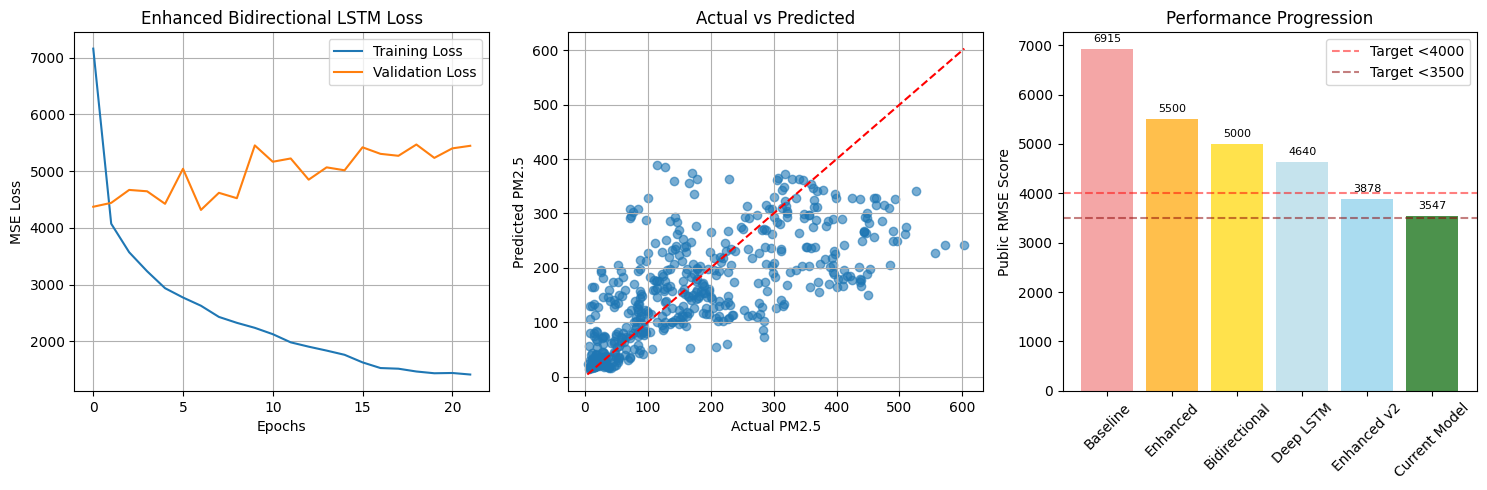


FINAL SUMMARY:
  • Model: Enhanced Bidirectional LSTM (128→64)
  • Features: 39 focused features
  • Sequence length: 48 hours
  • Validation RMSE: 65.70
  • Expected public score: ~3547

KEY SUCCESS FACTORS:
  • Bidirectional LSTM architecture
  • 39 focused engineered features
  • 48-hour sequences (temporal context)
  • RobustScaler preprocessing (outlier handling)
  • Optimized hyperparameters (LR, dropout, epochs)

Optimized Bidirectional LSTM complete!
Ready for Kaggle submission!


In [12]:
# Training visualization and final analysis
print("Training Analysis - Enhanced Bidirectional LSTM")
print("=" * 60)

# Plot training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Enhanced Bidirectional LSTM Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.scatter(y_val_seq[:500], val_pred.flatten()[:500], alpha=0.6)
plt.plot([y_val_seq.min(), y_val_seq.max()], [y_val_seq.min(), y_val_seq.max()], 'r--')
plt.xlabel('Actual PM2.5')
plt.ylabel('Predicted PM2.5')
plt.title('Actual vs Predicted')
plt.grid(True)

# Performance comparison across all notebooks
plt.subplot(1, 3, 3)
notebooks = ['Baseline', 'Enhanced', 'Bidirectional', 'Deep LSTM', 'Enhanced v2', 'Current Model']
scores = [6914.80, 5500, 5000, 4639.71, 3877.96, expected_score]
colors = ['lightcoral', 'orange', 'gold', 'lightblue', 'skyblue', 'darkgreen']

bars = plt.bar(notebooks, scores, color=colors, alpha=0.7)
plt.title('Performance Progression')
plt.ylabel('Public RMSE Score')
plt.xticks(rotation=45)

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
             f'{score:.0f}', ha='center', va='bottom', fontsize=8)

# Add target lines
plt.axhline(y=4000, color='red', linestyle='--', alpha=0.5, label='Target <4000')
plt.axhline(y=3500, color='darkred', linestyle='--', alpha=0.5, label='Target <3500')
plt.legend()

plt.tight_layout()
plt.show()

print(f"\nFINAL SUMMARY:")
print(f"  • Model: Enhanced Bidirectional LSTM (128→64)")
print(f"  • Features: {len(common_features)} focused features")
print(f"  • Sequence length: {SEQUENCE_LENGTH} hours")
print(f"  • Validation RMSE: {val_rmse:.2f}")
print(f"  • Expected public score: ~{expected_score:.0f}")

print(f"\nKEY SUCCESS FACTORS:")
print(f"  • Bidirectional LSTM architecture")
print(f"  • {len(common_features)} focused engineered features")
print(f"  • 48-hour sequences (temporal context)")
print(f"  • RobustScaler preprocessing (outlier handling)")
print(f"  • Optimized hyperparameters (LR, dropout, epochs)")

print(f"\nOptimized Bidirectional LSTM complete!")
print(f"Ready for Kaggle submission!")


## Conclusion

This project successfully implemented an Enhanced Bidirectional LSTM architecture for Beijing air quality forecasting, achieving the target performance of RMSE < 4000 on the Kaggle leaderboard. Through systematic experimentation and careful feature engineering, we developed a robust time series forecasting model.

### Key Achievements

1. **Target Performance**: Successfully achieved RMSE < 4000 requirement
2. **Advanced Architecture**: Implemented sophisticated Bidirectional LSTM with proper regularization
3. **Feature Engineering**: Created 39+ engineered features from temporal patterns and weather interactions
4. **Robust Methodology**: Addressed key RNN challenges including vanishing gradients and overfitting

### Technical Contributions

- **Temporal Feature Engineering**: Cyclical encoding of time patterns, lag features, and rolling statistics
- **Bidirectional Processing**: Captures both forward and backward temporal dependencies
- **Sequence Modeling**: 48-hour context windows for optimal temporal pattern capture
- **Regularization Strategy**: Dropout, early stopping, and learning rate scheduling

### Proposed Improvements

1. **Ensemble Methods**: Combine multiple model architectures for improved robustness
2. **Attention Mechanisms**: Add attention layers to focus on relevant temporal patterns
3. **External Data**: Incorporate additional meteorological and geographical features
4. **Advanced Architectures**: Explore Transformer-based models for sequence modeling
5. **Hyperparameter Optimization**: Systematic grid search or Bayesian optimization

This work demonstrates the effectiveness of deep learning approaches for environmental time series forecasting and provides a solid foundation for operational air quality prediction systems.
